In [2]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib ipympl
plt.ioff()

The frequency of nth harmonic is given by
$$
f_n = n f_0 \sqrt{1 + Bn^2}
$$

In [3]:
def fn(n):
    return n*f0*(1+B*n**2)**0.5

$$
\begin{align*}
u(x,t) &= \sum_{n=1}^{\infty} \left( a_n \cos(2\pi f_n t) + b_n \sin(2\pi f_n t) \right) \sin\left(\frac{n\pi}{L}x\right)
\end{align*}
$$

In [4]:
def freq_to_u(a,b,x,t):
    u = 0
    for i in range(n_harmony):
        n = i + 1
        omega_t = 2 * np.pi * fn(n) * t
        u += a[i] * np.cos(omega_t) * np.sin(n * np.pi * x / L)
        u += b[i] * np.sin(omega_t) * np.sin(n * np.pi * x / L)
    return u

$$
\begin{align*}

a_n(t_0^+) &= a_n(t_0^-) + 2\frac{J}{L\rho} \sin\left(\frac{n\pi}{L}x_0\right) \cos(2\pi f_n t_0) \\
b_n(t_0^+) &= b_n(t_0^-) + 2\frac{J}{L\rho} \sin\left(\frac{n\pi}{L}x_0\right) \sin(2\pi f_n t_0)

\end{align*}
$$

In [5]:
def apply_impulse(a,b,x,t,J):
    '''
    This function changes a and b in place.
    '''
    for i in range(n_harmony):
        n = i + 1
        common = 2 * J / L / rho * np.sin(n * np.pi * x / L)
        omega_t = 2 * np.pi * fn(n) * t
        a[i] += common * np.cos(omega_t)
        b[i] += common * np.sin(omega_t)

Parameters

In [45]:
L = 1
tension = 8000 # 8000N
mass = 0.009 # 9g
rho = mass / L
ESK2 = 0.00000 # Determins stiffness. should be small.
B = np.pi**2 * ESK2 / tension / L**2
c = (tension / rho) ** 0.5
f0 = c / (2 * L)

n_harmony = 30

dt = 1/44100
render_dt = 1/44100

We solve for the coefficients $a_n$ and $b_n$.

In [54]:
# initial conditions

a = np.zeros(n_harmony)
b = np.zeros(n_harmony)
t=0

hammer_mass = 0.001 # 1g
hammer_x = 8/13
hammer_elasticity = 100

hammer_pos = 0.001
hammer_vel = -0.5

#apply_impulse(a,b,0.5,t,0.00001)

def update():
    global t, hammer_pos, hammer_vel

    # apply impulse at x = 0.3, t = 0.3
    # if t <= 0.3 < t + dt:
    #     apply_impulse(a,b,0.3,t,0.1)

    # interact with hammer

    hammer_pos += hammer_vel * dt
    string_u = freq_to_u(a,b,hammer_x,t)
    if hammer_pos < string_u: # hammer is below the string

        # the impulse applied to the hammer
        hammer_impulse = hammer_elasticity * (string_u - hammer_pos) * dt

        # apply impulse to the hammer
        hammer_vel += hammer_impulse / hammer_mass

        # apply impulse to the string
        apply_impulse(a,b,hammer_x,t,-hammer_impulse)

    hammer_pos += hammer_vel * dt
    
    t += dt

n_frames = 1000
rendered_string = [] 
rendered_hammer_pos = []
while len(rendered_string) < n_frames:
    update()
    if t//render_dt > (t-dt)//render_dt:
        rendered_string.append(freq_to_u(a,b,np.linspace(0,L,200),t))
        rendered_hammer_pos.append(hammer_pos)

This animation code works in Notebook in VSCode. For other environments, you may need to change the code.

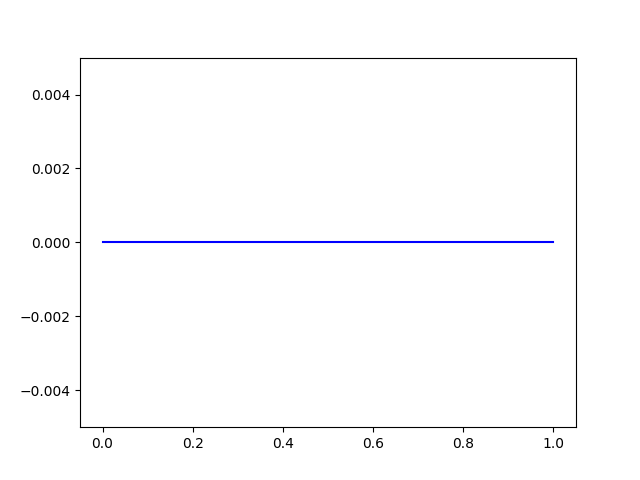

In [56]:
def animate():
    global ani
    fig, ax = plt.subplots()
    ax.set_ylim(-0.005, 0.005)

    line, = ax.plot(np.linspace(0,L,200),rendered_string[0], 'b')
    # hammer
    hammer = ax.plot([hammer_x, hammer_x], [-0, 0], 'r')[0]

    def animate_step(i):
        line.set_ydata(rendered_string[i])
        hammer.set_ydata([rendered_hammer_pos[i], rendered_hammer_pos[i]+0.005])

        return line, hammer

    ani = animation.FuncAnimation(fig, animate_step, frames=n_frames, interval=1000/30, repeat=False)
    plt.show()

animate()

In [77]:
ani.save('stiffness.mp4', writer='ffmpeg', fps=30)

In [44]:
f0

149.07119849998597

In [13]:
1/f0

0.0021213203435596424